In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from evaluate_utils import *
from sklearn.metrics import f1_score

In [2]:
train_previous_increase_ratio = np.load("../data/interim/stock500_2023_2024_previous_increase_ratio.npz")["previous_increase_ratio"]
train_post_increase_ratio = np.load("../data/interim/stock500_2023_2024_post_increase_ratio.npz")["post_increase_ratio"]
test_previous_increase_ratio = np.load("../data/interim/stock500_20250101_20250430_previous_increase_ratio.npz")["previous_increase_ratio"]
test_post_increase_ratio = np.load("../data/interim/stock500_20250101_20250430_post_increase_ratio.npz")["post_increase_ratio"]
valid_train_samples = (np.min(train_previous_increase_ratio, axis=1) > 0) & (np.min(train_post_increase_ratio, axis=1) > 0)
valid_test_samples = (np.min(test_previous_increase_ratio, axis=1) > 0) & (np.min(test_post_increase_ratio, axis=1) > 0)
train_previous_increase_ratio = train_previous_increase_ratio[valid_train_samples]
train_post_increase_ratio = train_post_increase_ratio[valid_train_samples]
test_previous_increase_ratio = test_previous_increase_ratio[valid_test_samples]
test_post_increase_ratio = test_post_increase_ratio[valid_test_samples]
# 数据标签
train_scores = np.max(train_post_increase_ratio, axis=1)
train_labels = np.max(train_post_increase_ratio, axis=1) >= 1.05
test_scores = np.max(test_post_increase_ratio, axis=1)
test_labels = np.max(test_post_increase_ratio, axis=1) >= 1.05
print("Shape of train_previous_increase_ratio: ", train_previous_increase_ratio.shape)
print("Shape of test_previous_increase_ratio: ", test_previous_increase_ratio.shape)
print("Shape of train_post_increase_ratio: ", train_post_increase_ratio.shape)
print("Shape of test_post_increase_ratio: ", test_post_increase_ratio.shape)
print("Number of positive samples in train data: ", train_labels.sum())
print("Number of positive samples in test data: ", test_labels.sum())

Shape of train_previous_increase_ratio:  (108998, 30)
Shape of test_previous_increase_ratio:  (22146, 30)
Shape of train_post_increase_ratio:  (108998, 5)
Shape of test_post_increase_ratio:  (22146, 5)
Number of positive samples in train data:  17986
Number of positive samples in test data:  5535


In [28]:
import faiss
train_embeddings = np.load("../data/interim/stock500_2023_2024_embeddings.npz")["embeddings"]
train_embeddings = train_embeddings[valid_train_samples]
test_embeddings = np.load("../data/interim/stock500_20250101_20250430_embeddings.npz")["embeddings"]
test_embeddings = test_embeddings[valid_test_samples]
norms_train = np.linalg.norm(train_embeddings, axis=1, keepdims=True)
normed_train_embeddings = train_embeddings / norms_train  # 归一化后的数据
norms_test = np.linalg.norm(test_embeddings, axis=1, keepdims=True)
normed_test_embeddings = test_embeddings / norms_test  # 归一化后的数据
index = faiss.IndexFlatIP(train_embeddings.shape[1])
index.add(train_embeddings)

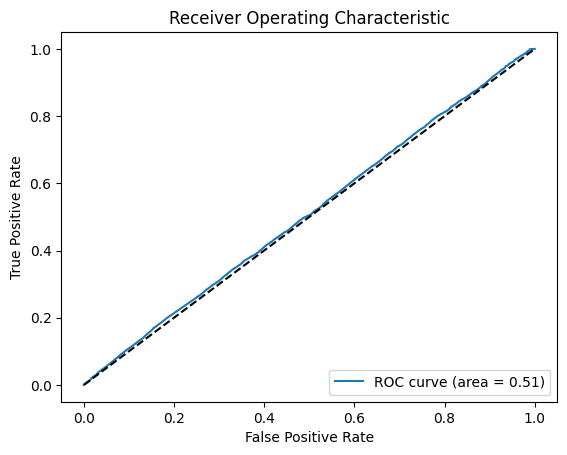

{'p90_th': 1.0442941833849662, 'p90_re': 0.0, 'p80_th': 1.0442941833849662, 'p80_re': 0.0, 'p70_th': 1.0442941833849662, 'p70_re': 0.0, 'p60_th': 1.0442941833849662, 'p60_re': 0.0, 'p50_th': 1.0442941833849662, 'p50_re': 0.0}


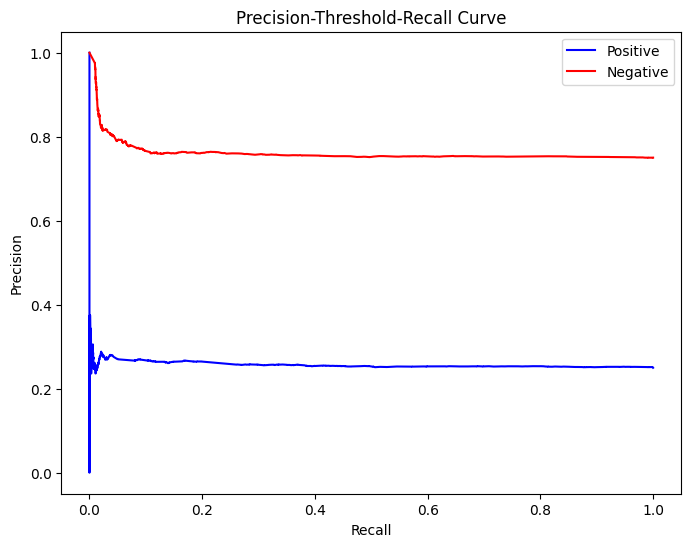

0.0
0.0000 0.5101 1.0443 0.0000 1.0443 0.0000 1.0443 0.0000 1.0443 0.0000 1.0443 0.0000


In [29]:
neighbors = index.search(normed_test_embeddings, 50)[1]
predictions = []
for i in range(test_previous_increase_ratio.shape[0]):
    predictions.append(np.median(train_scores[neighbors[i]]))
predictions = np.array(predictions)
model_name = f"knn+tstransformer"
metrics = {"model_name": f"knn+tstransformer"}
auc = plot_roc_curve(predictions, test_labels, model_name)
metrics["auc"] = auc
precision_threshold_recall_dict = plot_precision_threshold_recall(predictions, test_labels, model_name)
metrics.update(precision_threshold_recall_dict)
metrics["f1_score"] = f1_score(test_labels, predictions > metrics["p50_th"])
print(metrics["f1_score"])
print(f"{metrics['f1_score']:.4f} {metrics['auc']:.4f} {metrics['p90_th']:.4f} {metrics['p90_re']:.4f} {metrics['p80_th']:.4f} {metrics['p80_re']:.4f} {metrics['p70_th']:.4f} {metrics['p70_re']:.4f} {metrics['p60_th']:.4f} {metrics['p60_re']:.4f} {metrics['p50_th']:.4f} {metrics['p50_re']:.4f}")

In [30]:
print(normed_train_embeddings.shape)
print(normed_test_embeddings.shape)
print(neighbors.shape)

(108998, 512)
(22146, 512)
(22146, 50)


In [31]:
predictions

array([1.02128751, 1.02873486, 1.02748708, ..., 1.01960595, 1.02558226,
       1.02577584])

In [32]:
normed_train_embeddings[0]

array([-1.93064772e-02, -4.86459807e-02, -3.45674790e-02, -1.68711450e-02,
        2.93327030e-02,  9.54576731e-02,  4.57717143e-02,  2.48492602e-02,
        6.04063384e-02, -4.51374911e-02, -1.47357611e-02, -2.01666281e-02,
       -3.00722532e-02, -2.29203419e-04, -5.31196520e-02,  6.06234372e-02,
        4.17558923e-02, -1.42211060e-03, -2.43404005e-02, -2.30817832e-02,
        1.03893355e-02, -5.40519617e-02,  1.16529934e-01,  6.93195611e-02,
       -4.72493283e-02,  4.08136770e-02,  2.23602597e-02, -7.72981420e-02,
        3.65746021e-02, -6.96884841e-02, -3.23886052e-02,  6.72517121e-02,
        3.21933557e-03,  6.75846860e-02, -8.89985915e-03,  6.00958765e-02,
       -1.75249204e-02, -4.65660281e-02,  5.99466003e-02, -1.61180086e-02,
       -2.10686326e-02,  1.35693466e-02,  3.60595845e-02,  1.08976765e-02,
        8.89583956e-03,  1.42037915e-02,  2.08962103e-03, -7.04628322e-03,
        7.82328658e-03,  1.59755684e-02,  7.17283338e-02,  4.60038371e-02,
        1.07758017e-02,  